## Analyzing ADCP Data

In this notebook we look at acoustic backscatter in the different water masses based on ADCP data and show current measurements across the eddy

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import scipy.io

import scipy.signal
from random import random

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
import glob

all_files = glob.glob('data/sept_cruise/adcp/processed/*.mat')

In [4]:
files = []
for f in all_files:
    files.append(f.split('100s')[0])
filenames = list(np.unique(files))
filenames = [f+'100s' for f in filenames]

In [5]:
datetimes = [datetime.strptime(f.split('_')[2][:-5], '%Y%m%dT%H%S') for f in filenames]

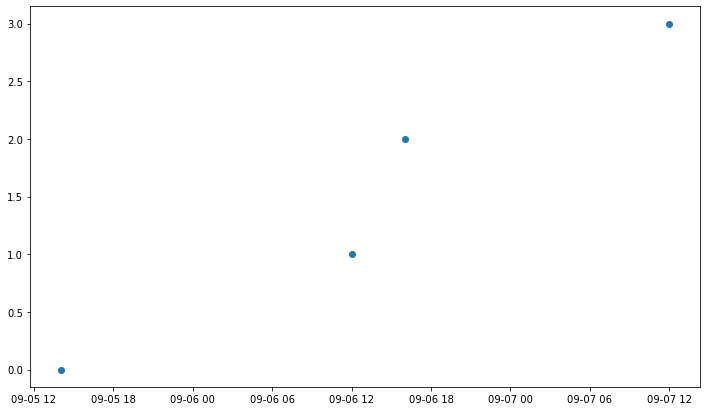

In [6]:
fig,ax = plt.subplots(figsize=(12,7))
ax.scatter(datetimes, range(len(datetimes)))

### pulling in profile code

In [7]:
! pip install colour

  Using cached colour-0.1.5-py2.py3-none-any.whl (23 kB)


In [8]:
! pip install geopy

  Using cached geopy-2.3.0-py3-none-any.whl (119 kB)
  Using cached geographiclib-2.0-py3-none-any.whl (40 kB)


In [9]:
# yes I realize this is an ugly brute force way to do this but it works

In [12]:
count = 0

vmp_fns = glob.glob('data/VMP/2020*.mat')
vmp_fns.sort()

names = ['t'+str(i) for i in np.arange(count,len(vmp_fns)+count)]
count += len(vmp_fns)

li = []
for i, fn in enumerate(vmp_fns):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df_tmp = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df_tmp['transect'] = names[i]
            df_tmp['profile_num'] = names[i]+'_'+item.split('profile')[-1]
            li.append(df_tmp)

profiles_2020 = pd.concat(li, axis=0, ignore_index=True)
profiles_2020['dt'] = pd.to_datetime('2020-1-1') + pd.to_timedelta(profiles_2020.time, unit='D') - pd.Timedelta(days=1)
profiles_2020 = profiles_2020.set_index('dt')
profiles_2020 = profiles_2020.sort_index(ascending=True)
profiles_2020['datetime'] = pd.to_datetime('2020-1-1') + pd.to_timedelta(profiles_2020.time, unit='D') - pd.Timedelta(days=1)

In [11]:
count = 0

vmp_fns = glob.glob('data/sept_cruise/VMP/*.mat')
vmp_fns.sort()

names = ['t'+str(i) for i in np.arange(count,len(vmp_fns)+count)]
count += len(vmp_fns)

li = []
for i, fn in enumerate(vmp_fns):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df_tmp = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df_tmp['transect'] = names[i]
            df_tmp['profile_num'] = names[i]+'_'+item.split('profile')[-1]
            li.append(df_tmp)

profiles_2021 = pd.concat(li, axis=0, ignore_index=True)
profiles_2021['dt'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles_2021.time, unit='D') - pd.Timedelta(days=1)
profiles_2021 = profiles_2021.set_index('dt')
profiles_2021 = profiles_2021.sort_index(ascending=True)
profiles_2021['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(profiles_2021.time, unit='D') - pd.Timedelta(days=1)

In [12]:
profiles = profiles_2021

In [14]:
vmp_fns = glob.glob('data/VMP/VMP*.mat')
vmp_fns.sort()

names = ['t'+str(i) for i in np.arange(count,len(vmp_fns)+count)]
count += len(vmp_fns)

li = []
for i, fn in enumerate(vmp_fns):
    mat = scipy.io.loadmat(fn)
    for item in list(mat.keys()):
        if item not in ['__header__', '__version__', '__globals__']:
            df_tmp = pd.DataFrame(data=mat[item], columns=['time', 'depth (dBars)', 'temp (C)','salinity (PSU)', 'potential density (kg/m^3 -1000)', 
                                                    'chla (ppb)', 'turbidity (FTU)', 'turb kinetic energy 1 (W/kg)', 'turb kinetic energy 2 (W/kg)'])
            df_tmp['transect'] = names[i]
            df_tmp['profile_num'] = names[i]+'_'+item.split('profile')[-1]
            li.append(df_tmp)

profiles_2022 = pd.concat(li, axis=0, ignore_index=True)
profiles_2022['dt'] = pd.to_datetime('2022-1-1') + pd.to_timedelta(profiles_2022.time, unit='D') - pd.Timedelta(days=1)
profiles_2022 = profiles_2022.set_index('dt')
profiles_2022 = profiles_2022.sort_index(ascending=True)
profiles_2022['datetime'] = pd.to_datetime('2022-1-1') + pd.to_timedelta(profiles_2022.time, unit='D') - pd.Timedelta(days=1)

In [15]:
profiles = pd.concat([profiles_2020,profiles_2021,profiles_2022])

In [13]:
from geopy import distance

def get_dist(df, df_start, flip=False):
    distances = []
    # flip allows you to swap the starting side so that it can always do dist from the same side
    if flip == False:
        first_row = df_start.iloc[0]
    else:
        first_row = df_start.iloc[-1]
    for row in df.itertuples(index=False):
        distances.append(distance.distance((row.lat, row.lon),(first_row.lat,first_row.lon)).meters)
    return(distances)

In [14]:
def profile_locs(df, adcp_df):
    # add in lat and lon
    lats = []
    lons = []
    dists = []
    for i in range(len(df)):
        row = adcp_df.iloc[adcp_df.index.get_loc(pd.to_datetime(df.iloc[i].datetime), method='nearest')]
        lats.append(row.lat)
        lons.append(row.lon)
        dists.append(row.dist)
    df['lat'] = lats
    df['lon'] = lons
    df['dist'] = dists

    # now make it the same for each profile depending on the first row with that profile_num
    profile_nums = df.profile_num.unique()
    profile_num_idx = 0
    
    lats = []
    lons = []
    dists = []
    for row in df.itertuples(index=False):
#         print(profile_num_idx)
        try:
            if row.profile_num == profile_nums[profile_num_idx]:
                top_lat = row.lat
                top_lon = row.lon
                dist = row.dist
                profile_num_idx+=1
        except IndexError:
#             print('index error')
            pass
        lats.append(top_lat)
        lons.append(top_lon)
        dists.append(dist)
        
    df['lat'] = lats
    df['lon'] = lons
    df['dist'] = dists
    return(df)

In [15]:
from colour import Color
def plot_profiles(df, adcp_df, start_time, end_time, data_variables, plot=False):

#     print('##############################')
# #     print('Transect ' + str(i+1))
#     print('##############################')
    df_subset = df.loc[start_time:end_time]
    
    df_subset = profile_locs(df_subset, adcp_df)
    
    fig, ax = plt.subplots(1,4, figsize=(30,5))
    
    if len(df_subset) == 0:
        print('Did not have profile data.')
        return(ax)
    
    # Original data (e.g. measurements)
    for i, data_var in enumerate(data_variables):
        if plot:
            cmap='viridis'
            norm=None
#             fig, ax = plt.subplots(figsize=(17.2,7))
            if data_var == 'temp (C)':
                cmap = cmocean.cm.thermal
#                 vmin=21
#                 vmax=27.5
            elif data_var == 'salinity (PSU)':
                cmap = cmocean.cm.haline
                pass
#                 vmin=34.8
#                 vmax=36.2
            elif data_var == 'potential density (kg/m^3 -1000)':
                cmap = cmocean.cm.dense
#                 vmin=22.5
#                 vmax=23.5
            elif data_var == 'chla (ppb)':
                vmin=0.0
                vmax=0.6
                cmap = cmocean.cm.algae
            elif data_var == 'turbidity (FTU)':
                pass
#                 vmin=1
#                 vmax=1.12
            elif data_var == 'turb kinetic energy 1 (W/kg)':
                vmin=1e-10
                vmax=1e-6
                norm=mat_colors.LogNorm()
            elif data_var == 'turb kinetic energy 2 (W/kg)':
                vmin=1e-10
                vmax=1e-6
                norm=mat_colors.LogNorm()
            elif data_var == 'cluster':
                vmin=0
                vmax=6
                cmap='jet'
#                 norm=mat_colors.LogNorm()
                
#             flip=False
#             if transect in [1,8]:
#                 flip=True
            
#             df_subset_distances = get_dist(df_subset, adcp_df.loc[start_time:end_time], flip=False)
            if data_var == 'predicted_chla':
                var_to_viz = lr.predict(df_subset.turbidity_clean.values.reshape(-1,1))
            elif data_var == 'chla_bb':
                var_to_viz = df_subset.chla_clean/df_subset.turbidity_clean
            elif data_var == 'real_predict_chla':
                var_to_viz = df_subset.chla_clean/lr.predict(df_subset.turbidity_clean.values.reshape(-1,1))
            elif data_var == 'chla_sal':
                var_to_viz = df_subset.chla_clean/df_subset['salinity (PSU)']
            else:
                var_to_viz = df_subset[data_var]

            vmin = np.nanpercentile(var_to_viz, 8)
            vmax = np.nanpercentile(var_to_viz, 92)
            if data_var == 'ekbackscatter':
                vmin=97.5
                vmax=115
            if data_var == 'cluster':
                vmin=0
                vmax=6
            if data_var == 'salinity (PSU)':
                vmin=35
                vmax=36.5
            if data_var == 'chla (ppb)':
                vmin=0
                vmax=0.6
                cmap = cmocean.cm.algae
            if data_var == 'turbidity (FTU)':
                vmin=1
                vmax=2.5
                cmap = cmocean.cm.turbid
            if data_var == 'predicted_chla':
                vmin=0
                vmax=0.6
                cmap = cmocean.cm.algae
            if data_var == 'chla_clean':
                vmin=0
                vmax=0.6
                cmap = cmocean.cm.algae
            if data_var == 'chla_bb':
                vmin=0.0
                vmax=.8
            if data_var == 'chla_sal':
                vmin = 0.005
                vmax = 0.045
            if data_var == 'real_predict_chla':
                vmin=1.4
                vmax=.6
                cmap='cividis'
                
                
            sc = ax[i].scatter(df_subset['dist'], df_subset['depth (dBars)'],c=var_to_viz,cmap=cmap, s=150, alpha=.7, vmin=vmin,vmax=vmax,)# norm=norm)
            
#             if transect==0:
                
#                 Sep 05 2021 13:15:33 [System UTC, header]
#                 Sep 05 2021 15:21:30 [System UTC, header]
#                 Sep 05 2021 17:14:42 [System UTC, header]
                        
                
#                 if data_var == 'temp (C)':
#                     for t_string in ['Sep 05 2021 13:15:33']:
#                         df_idx = df_subset.index.get_loc(pd.to_datetime('Sep 05 2021 13:15:33'), method='nearest')
#                         ax.scatter(df_subset_distances, df_subset['depth (dBars)'],c=df_subset[data_var]
            
#             sc = ax.scatter(df_subset['datetime'], df_subset['depth (dBars)'],c=df_subset[data_var],cmap=cmap, s=150, alpha=.7, vmin=vmin,vmax=vmax, norm=norm)
            ax[i].set_ylim(-120,0)
#             ax.set_xlim(df_subset['datetime'].max()+timedelta(hours=.1),df_subset['datetime'].min()-timedelta(hours=.1))
            cb = fig.colorbar(sc,ax=ax[i])
#             cb.set_label(data_var)
            ax[i].set_title(data_var)
#             depths = [-5,-10,-20,-30,-60]
        
#             colors = list(Color("black").range_to(Color("blue"),len(depths)))
#             hex_colors = [j.hex for j in colors]
#             # integrate down to z depth
#             ax2 = ax.twinx()
#             for idx,z in enumerate(depths):
#                 # cut it off at depth (dBars) >= z
#                 df_tmp = df_subset[df_subset['depth (dBars)'] >= z] 
#                 df_tmp_grouped = df_tmp.groupby('profile_num').mean()
#                 df_tmp_grouped['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(df_tmp_grouped.time, unit='D') - pd.Timedelta(days=1)


#                 ax2.plot(df_tmp_grouped['datetime'],df_tmp_grouped[data_var], label=str(z), color=hex_colors[idx])
#                 ax2.set_ylim(vmin,vmax)
#                 ax2.legend(loc='lower left',title='Depth Integrated Values')
            
            
        
            ax[i].set_ylabel('Depth (m')
            ax[i].set_xlabel('Distance (m)')
#             ax.set_xlim(pd.to_datetime(start_time), pd.to_datetime(end_time))
#             ax.set_xlim(pd.to_datetime(end_time),pd.to_datetime(start_time))
        #     ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
#     fig.autofmt_xdate(rotation=45)
#             ax.xaxis.set_major_locator(plt.MaxNLocator(15))
#             print(data_var[:20]+'.png')
#             fig.savefig('figs/sept_transect_'+str(transect+1)+'_'+data_var[:20]+'.png')
    return(ax)

In [16]:
from colour import Color
def grab_vmp_data(df, adcp_df, start_time, end_time):

    df_subset = df.loc[start_time:end_time]
    df_subset['DOY'] = df_subset.datetime.dt.day_of_year
    df_subset.sort_index(inplace=True, ascending=True)
    
    df_subset = profile_locs(df_subset, adcp_df)
    z = -4.5
    df_tmp = df_subset[df_subset['depth (dBars)'] >= z] 
    df_tmp_grouped = df_tmp.groupby('profile_num').mean()
    
    df_tmp_grouped.sort_values('dist', inplace=True)
    
    return(df_tmp_grouped['salinity (PSU)'].values, df_tmp_grouped['temp (C)'].values, df_tmp_grouped['chla (ppb)'].values, df_tmp_grouped['turbidity (FTU)'].values, df_tmp_grouped['DOY'].values, df_tmp_grouped['dist'].values)
    

In [17]:
plt.rcParams.update({'font.size': 16})

In [27]:
dist_list = []
front_location_list = []
sst_list = []
current_list = []
echo_list = []
interp_sst_list = []
interp_current_list = []
interp_echo_list = []

sal_front_list = []

vmp_sal_list = []
vmp_temp_list = []
vmp_chla_list = []
vmp_dt_list = []

for idx,fn in enumerate(filenames):
    if idx in [0,1,2,3]:
        continue
    try:
        ##########
        
        dist = scipy.io.loadmat(fn+'_distance.mat')['distance']
        sst = scipy.io.loadmat(fn+'_SST.mat')['SST']
        time = scipy.io.loadmat(fn+'_time.mat')['time']
        timestamps = pd.to_datetime(time[0,:]-719529, unit='D')
  
        lat = scipy.io.loadmat(fn+'_lat.mat')['lat']
        long = scipy.io.loadmat(fn+'_long.mat')['long']
        
        # the distances are crazy wrong sometimes so re-calcuating the distance
        coords_1 = (lat[0], long[0])
        distances = []
        for i in range(len(lat)):
            coords_2 = (lat[i], long[i])
            distances.append(distance.geodesic(coords_1, coords_2).meters)
        dist = np.array(distances)       

        # checking if the current point is within 500 of one that was good, assuming the first point is good
        # then if not setting it to nan and interpolating it out
        last_good_idx = 0
        bad_idxs = []
        for di,d in enumerate(dist):
            if dist[di] - dist[last_good_idx] < 500:
                last_good_idx = di
            else:
                bad_idxs.append(di)
        dist[bad_idxs] = np.nan
        dist = pd.Series(dist).interpolate().values

        dist = dist.reshape(-1,1)
        
        adcp_df = pd.DataFrame({'dt':timestamps,
                    'datetime':timestamps,
                    'sst':sst[:,0],
                    'lat': lat[:,0],
                    'lon':long[:,0],
                    'dist':dist[:,0]})

        adcp_df = adcp_df.set_index('dt')
        adcp_df = adcp_df.sort_index(ascending=True)
        
        
        ##########
        
        sal_vmp, temp_vmp, chla_vmp, turb_vmp, dt_vmp, dist_vmp = grab_vmp_data(profiles, adcp_df, timestamps[0],timestamps[-1])
            
        vmp_sal_list.append(sal_vmp)
        vmp_temp_list.append(temp_vmp)
        vmp_chla_list.append(chla_vmp)
        vmp_dt_list.append(dt_vmp)
        

    except Exception as e: 
        print(e)



cannot convert input with unit 'D'


how many transects do we have with VMP data

In [22]:
import gsw

This defines some parameters for the echosounder backscatter calculations

In [25]:
ed_gs_depth = 35*2
shelf_depth = 8*2

gulf_stream_ek = []
eddy_ek = []
shelf_ek = []

In [38]:
profiles['ekbackscatter'] = np.nan
profiles['current_mag'] = np.nan

for idx,fn in enumerate(filenames):
    ##########
#     else:
    dist = scipy.io.loadmat(fn+'_distance.mat')['distance']
    sst = scipy.io.loadmat(fn+'_SST.mat')['SST']
    time = scipy.io.loadmat(fn+'_time.mat')['time']
    timestamps = pd.to_datetime(time[0,:]-719529, unit='D')


#         if idx in [5,28,39,40,41]:
#             dist = (dist - dist[-1])*-1

    X = scipy.io.loadmat(fn+'_X.mat')['X']
    Y = scipy.io.loadmat(fn+'_Y.mat')['Y']
    vMag = scipy.io.loadmat(fn+'_vmag.mat')['C']

    vDir = scipy.io.loadmat(fn+'_vdir.mat')['C']

    vShear = scipy.io.loadmat(fn+'_vshear.mat')['C']

    echo = scipy.io.loadmat(fn+'_echo.mat')['C']
    Xecho = scipy.io.loadmat(fn+'_Xecho.mat')['X']
    Yecho = scipy.io.loadmat(fn+'_Yecho.mat')['Y']

    # correcting for the smaller bin size
    Yecho = (Yecho*0.502)-1

    echo_reshape = echo.reshape(-1,127).T
    vMag_reshape = vMag.reshape(-1,69).T

    lat = scipy.io.loadmat(fn+'_lat.mat')['lat']
    long = scipy.io.loadmat(fn+'_long.mat')['long']

    # the distances are crazy wrong sometimes so re-calcuating the distance
    coords_1 = (lat[0], long[0])
    distances = []
    for i in range(len(lat)):
        coords_2 = (lat[i], long[i])
        distances.append(distance.geodesic(coords_1, coords_2).meters)
    dist = np.array(distances)       
#         bogus_dist_locations = dist > 35000        
#         dist[dist > 25000] = np.nan
#         dist = pd.Series(dist).interpolate().values
    # checking if the current point is within 500 of one that was good, assuming the first point is good
    # then if not setting it to nan and interpolating it out
    last_good_idx = 0
    bad_idxs = []
    for di,d in enumerate(dist):
        if dist[di] - dist[last_good_idx] < 500:
            last_good_idx = di
        else:
            bad_idxs.append(di)
    dist[bad_idxs] = np.nan
    dist = pd.Series(dist).interpolate().values

    dist = dist.reshape(-1,1)

    adcp_df = pd.DataFrame({'dt':timestamps,
                'datetime':timestamps,
                'sst':sst[:,0],
                'lat': lat[:,0],
                'lon':long[:,0],
                'dist':dist[:,0]})

    adcp_df = adcp_df.set_index('dt')
    adcp_df = adcp_df.sort_index(ascending=True)


    # find the adcp data with the closest location to each profile in distance space 
    # and then grab the echosounder data from that

    # the logic could be
    # grab the closest ek sounding in time with the profile data
    # then use that distance to average +/- the last 10 EK soundings
    # interpolate that into the profile depth and don't extrapolate
    # do this for each transect via just having a time tolerance of ~30 seconds
    profiles_subset = profiles.loc[timestamps[0]:timestamps[-1]]
    profiles_subset = profile_locs(profiles_subset, adcp_df)

    profile_nums = profiles_subset.profile_num.unique()
    profile_num_idx = 0

    for row in profiles_subset.itertuples(index=False):
        try:
            if row.profile_num == profile_nums[profile_num_idx]:
#                     print(np.abs(dist - row.dist).min())
                dist_arg = np.abs(dist - row.dist).argmin()
                # we don't want the matchs to be very far away and better to keep as nans if so
                if np.abs(dist - row.dist).min() > 5:
                    print('greater than 5m')
                    continue
                ek_for_profile = np.interp(abs(profiles_subset[profiles_subset.profile_num == profile_nums[profile_num_idx]]['depth (dBars)'].values), abs(Yecho[:127,0]), np.nanmedian(echo_reshape[:,dist_arg-20:dist_arg+20],axis=1),left=np.nan, right=np.nan)
                mag_for_profile = np.interp(abs(profiles_subset[profiles_subset.profile_num == profile_nums[profile_num_idx]]['depth (dBars)'].values), abs(Y[:69,0]), np.nanmedian(vMag_reshape[:,dist_arg-20:dist_arg+20],axis=1),left=np.nan, right=np.nan)


                m = profiles_subset.profile_num == profile_nums[profile_num_idx]

                profiles_subset.loc[m,'ekbackscatter'] = ek_for_profile
                profiles_subset.loc[m,'current_mag'] = mag_for_profile

                profile_num_idx+=1

        except IndexError:
    #         print('index error')
            pass

    profiles.loc[timestamps[0]:timestamps[-1],'ekbackscatter'] = profiles_subset.ekbackscatter 
    profiles.loc[timestamps[0]:timestamps[-1],'current_mag'] = profiles_subset.current_mag 
#         break
        



In [39]:
1

1

In [40]:
ek_for_profile = np.interp(abs(profiles_subset[profiles_subset.profile_num == profile_nums[profile_num_idx-1]]['depth (dBars)'].values), abs(Yecho[:127,0]), np.nanmedian(echo_reshape[:,dist_arg-20:dist_arg+20],axis=1),left=np.nan, right=np.nan)

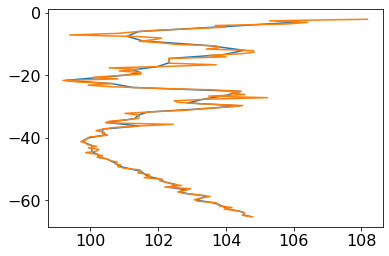

In [41]:
plt.plot(ek_for_profile,profiles_subset[profiles_subset.profile_num == profile_nums[profile_num_idx-1]]['depth (dBars)'].values)
plt.plot(np.nanmedian(echo_reshape[:,dist_arg-20:dist_arg+20],axis=1),Yecho[:127,0])

In [42]:
vmag_for_profile = np.interp(abs(profiles_subset[profiles_subset.profile_num == profile_nums[profile_num_idx-1]]['depth (dBars)'].values), abs(Y[:69,0]), np.nanmedian(vMag_reshape[:,dist_arg-20:dist_arg+20],axis=1),left=np.nan, right=np.nan)

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


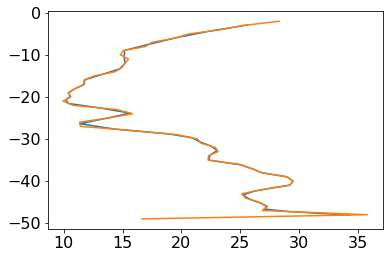

In [43]:
plt.plot(vmag_for_profile,profiles_subset[profiles_subset.profile_num == profile_nums[profile_num_idx-1]]['depth (dBars)'].values)
plt.plot(np.nanmedian(vMag_reshape[:,dist_arg-20:dist_arg+20],axis=1),Y[:69,0])

In [44]:
# Figure out boudaries (mins and maxs)
smin = 32-.7
smax = 37+.7
tmin = 8-.7 
tmax = 30+.7

# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Substract 1000 to convert to sigma-t
dens = dens - 1000

In [45]:
import cmocean

0
data/sept_cruise/adcp/processed/101706_20210905T145056UTC_100s
---
05. September 2021 02:00PM UTC


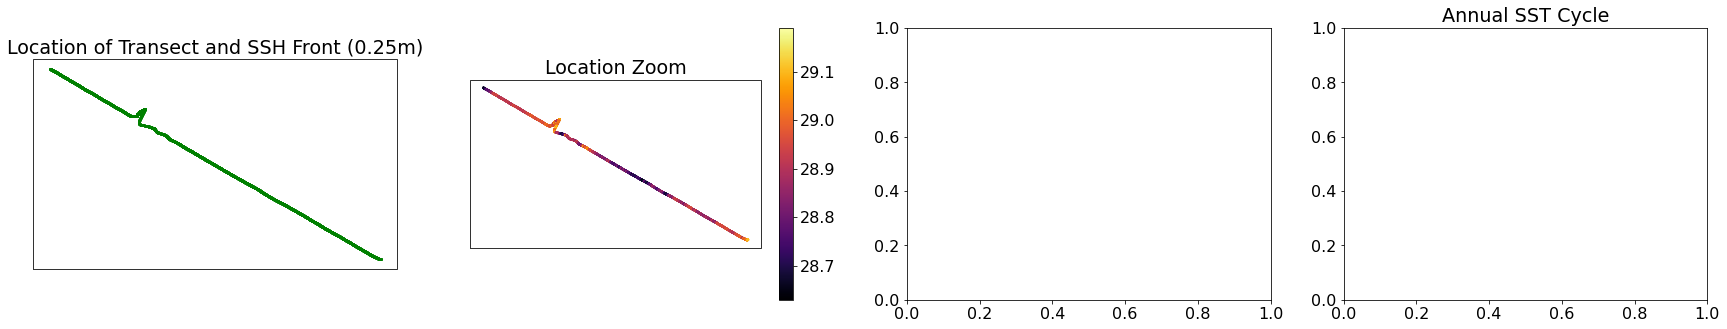

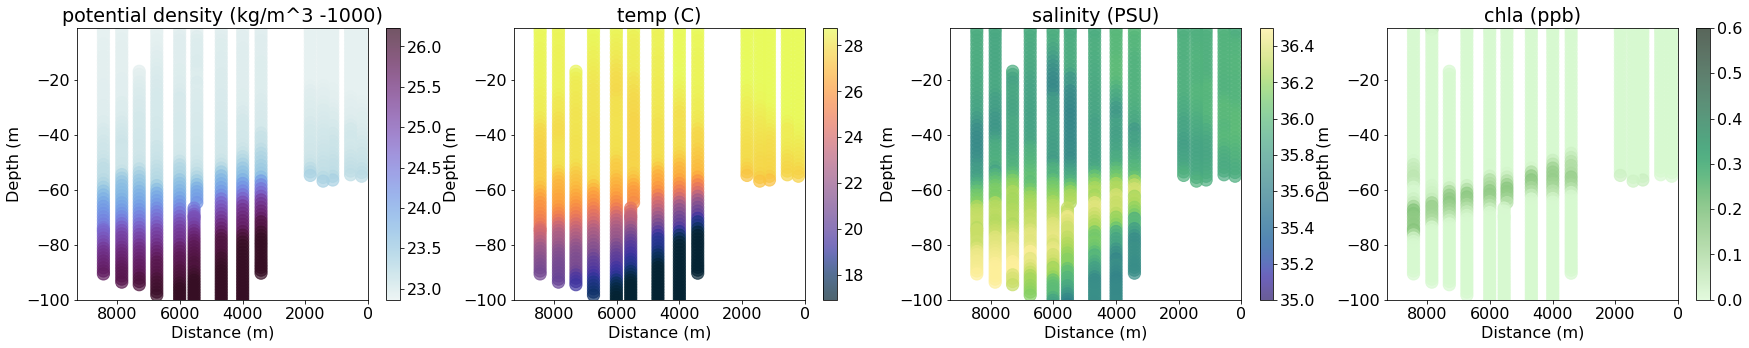

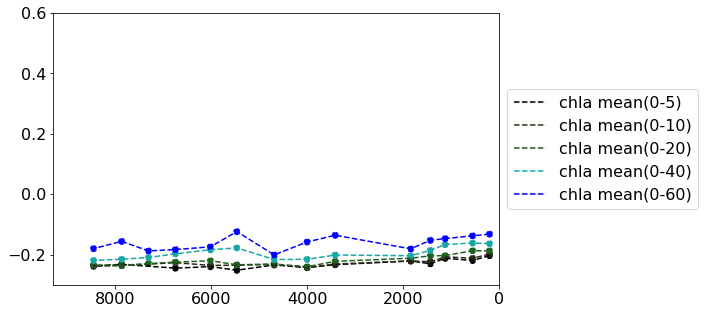

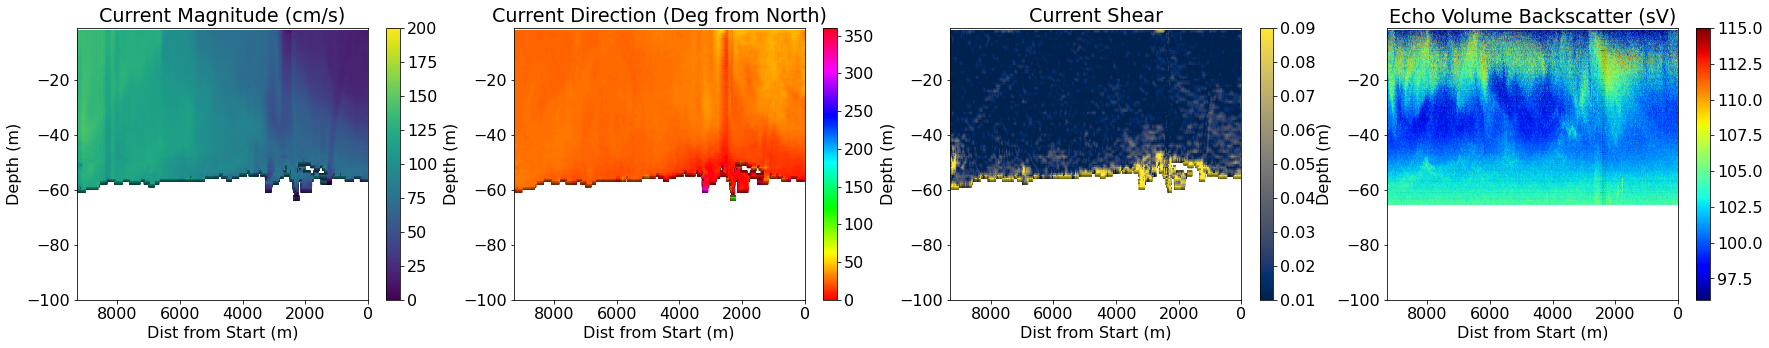

##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
1
data/sept_cruise/adcp/processed/101706_20210906T121429UTC_100s
---
06. September 2021 12:00PM UTC


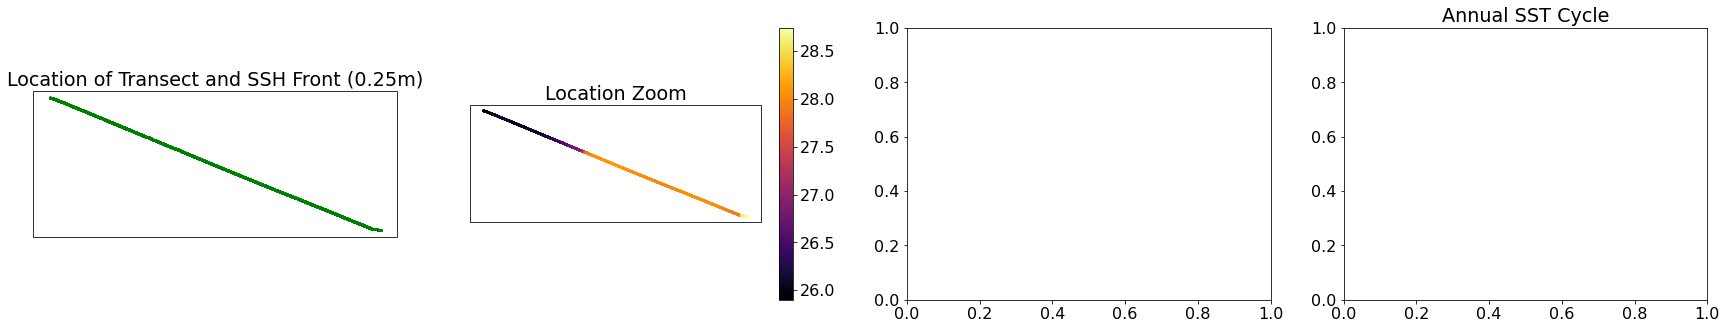

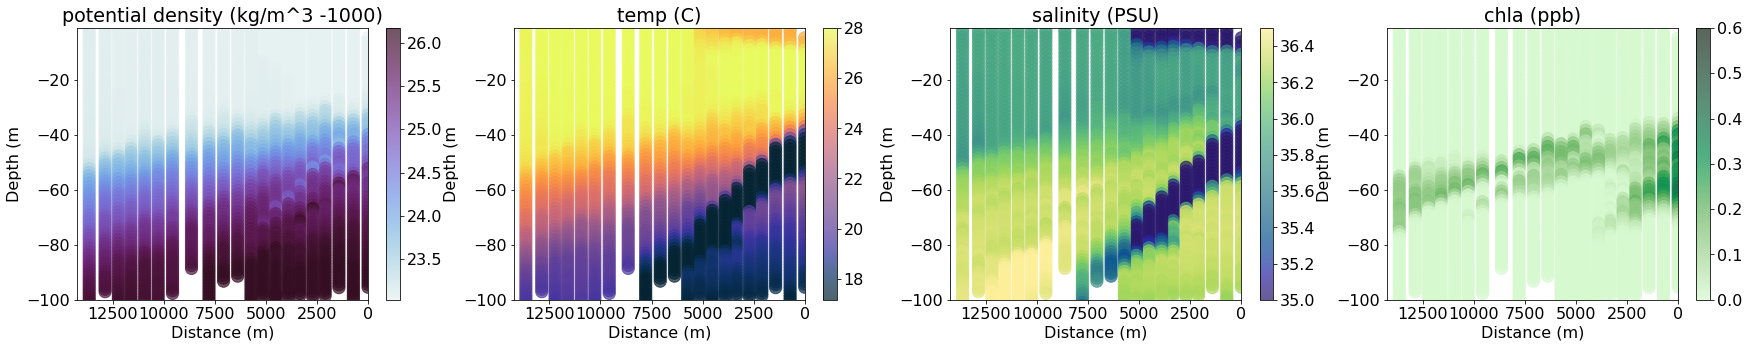

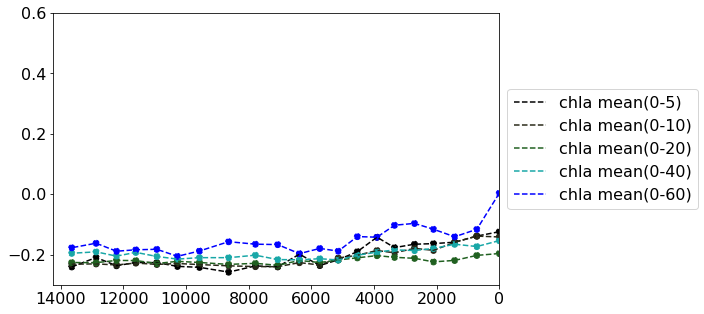

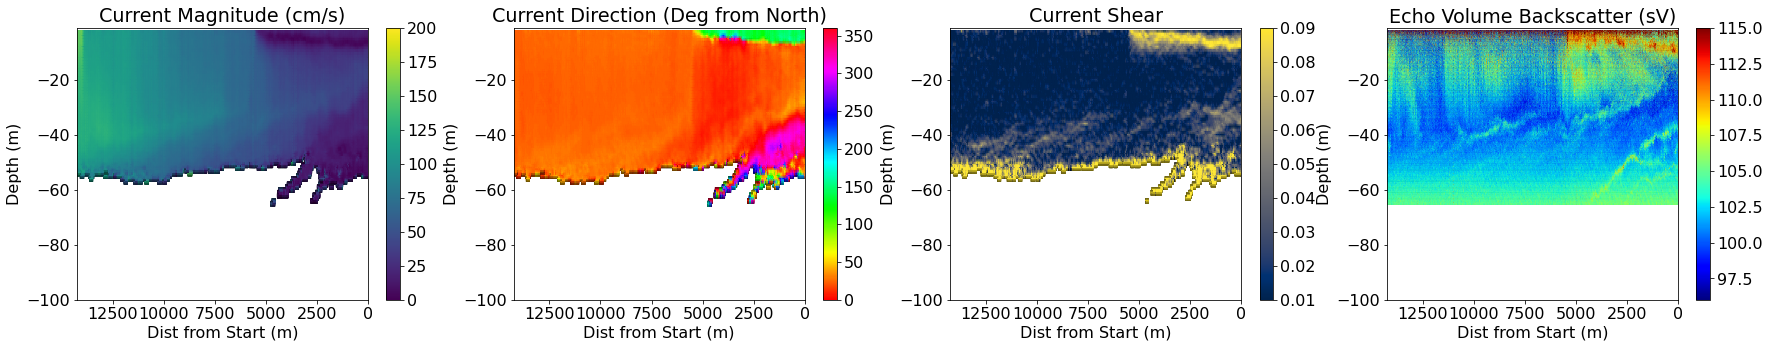

##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
2
data/sept_cruise/adcp/processed/101706_20210906T164454UTC_100s
---
06. September 2021 04:00PM UTC


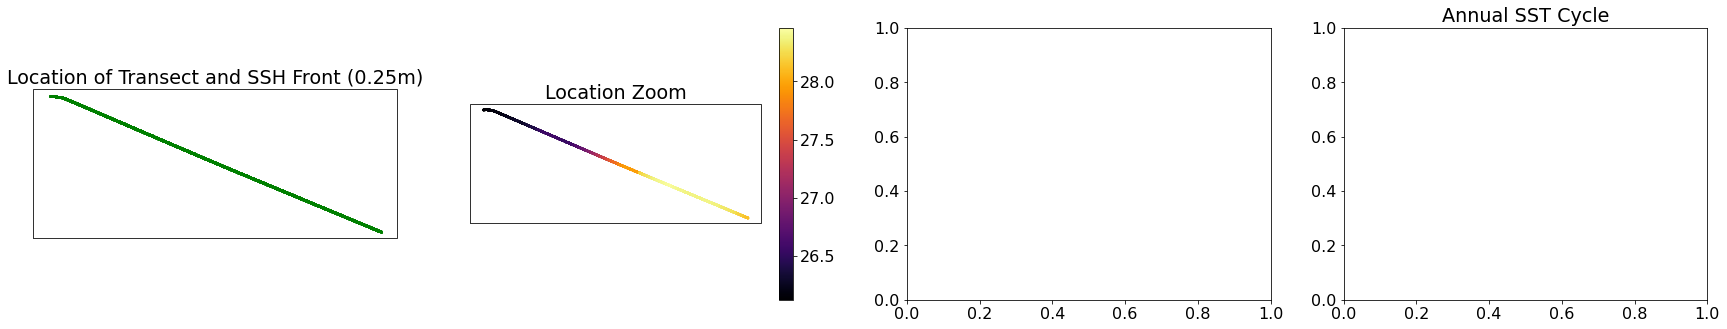

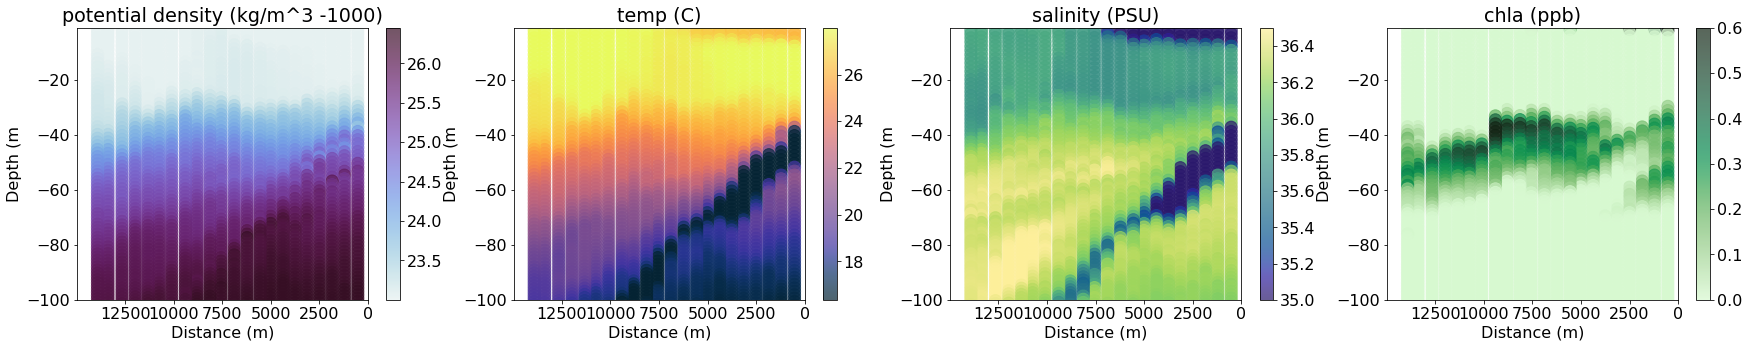

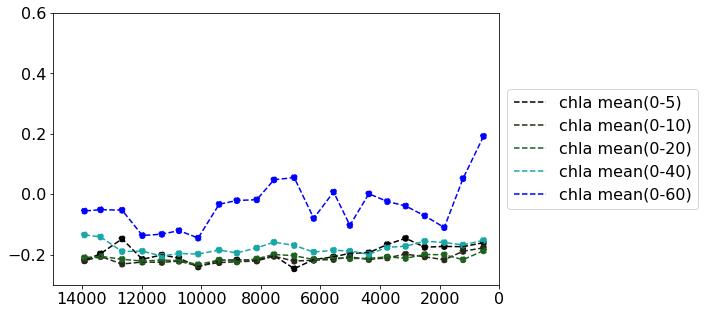

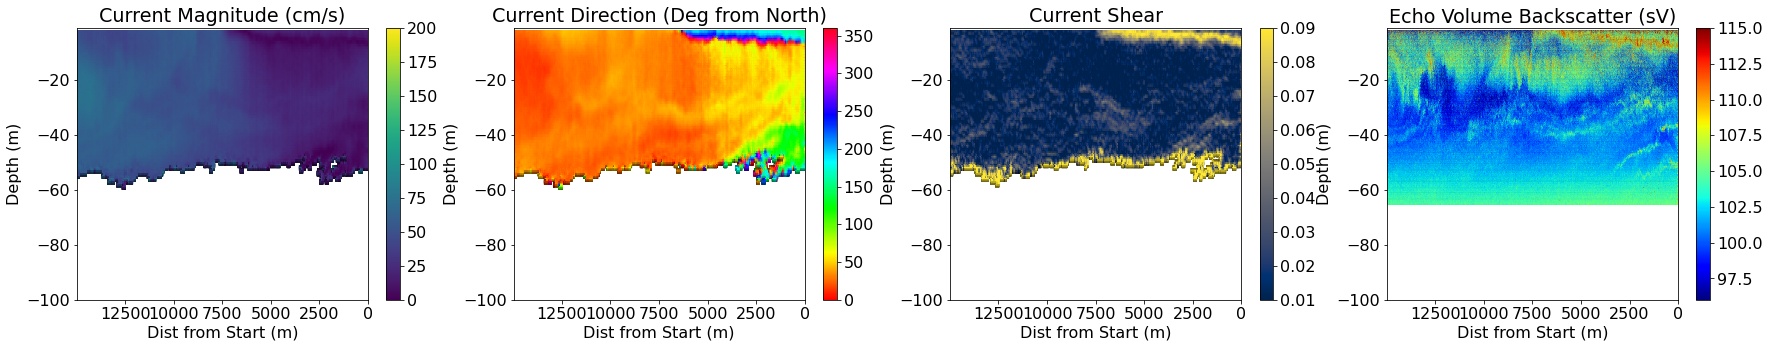

##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
3
data/sept_cruise/adcp/processed/101706_20210907T123502UTC_100s
---
07. September 2021 12:00PM UTC


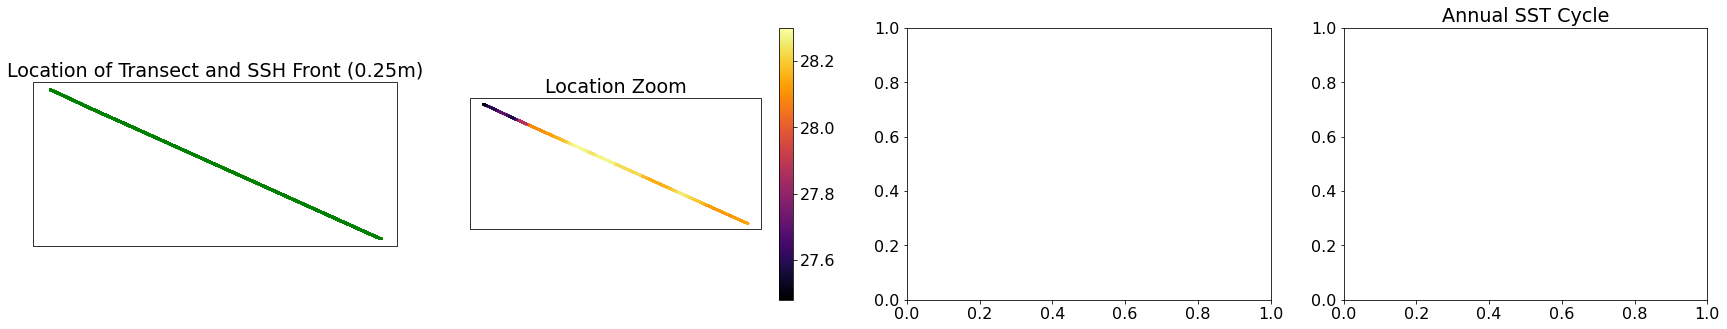

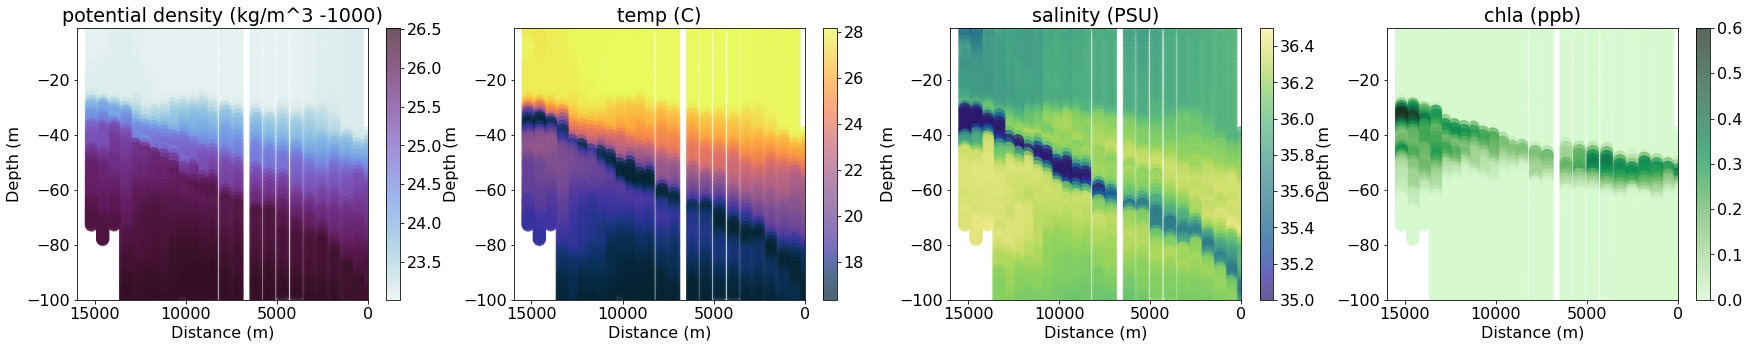

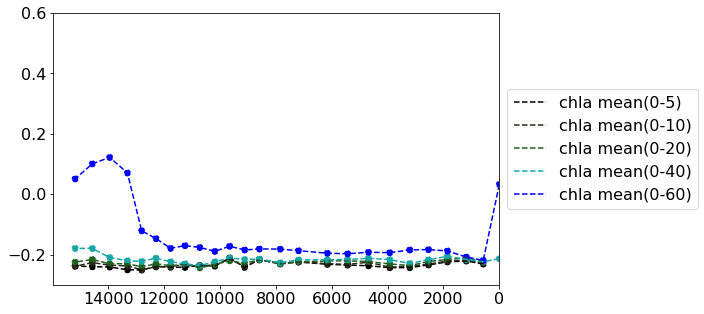

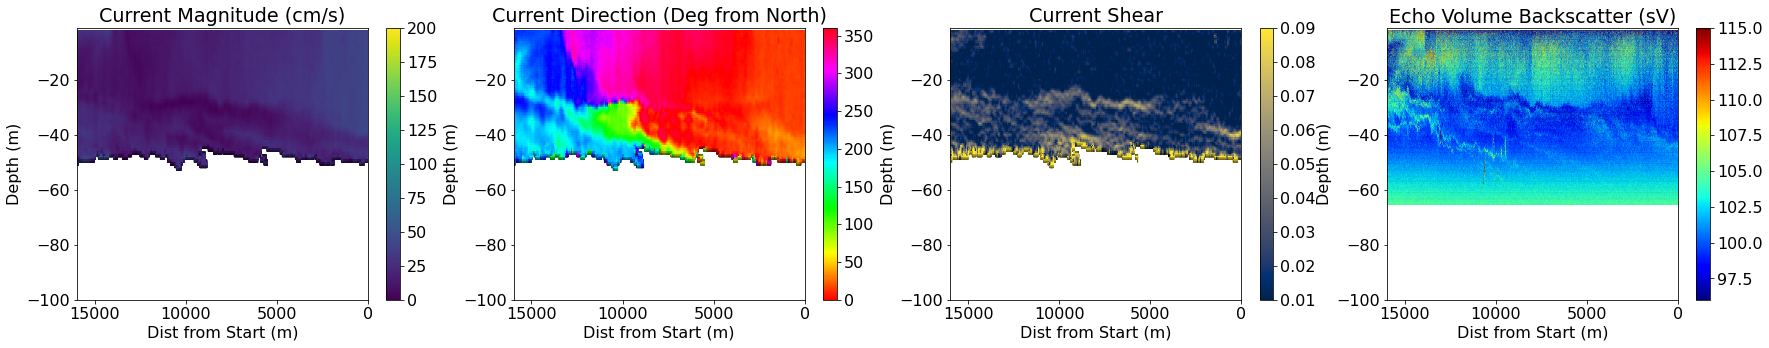

##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################
##################################################################################################################################################


In [60]:
front_transects = []
front_locations = []
time_starts = []
time_stops = []

for idx,fn in enumerate(filenames):
    print(idx)
    print(fn)
    print('---')
    print(datetimes[idx].strftime("%d. %B %Y %I:%M%p UTC"))
    
    try:

        dist = scipy.io.loadmat(fn+'_distance.mat')['distance']
        sst = scipy.io.loadmat(fn+'_SST.mat')['SST']
        time = scipy.io.loadmat(fn+'_time.mat')['time']
        timestamps = pd.to_datetime(time[0,:]-719529, unit='D')
    
       
        
#         if idx in [5,28,39,40,41]:
#             dist = (dist - dist[-1])*-1
        
        X = scipy.io.loadmat(fn+'_X.mat')['X']
        Y = scipy.io.loadmat(fn+'_Y.mat')['Y']
        vMag = scipy.io.loadmat(fn+'_vmag.mat')['C']

        vDir = scipy.io.loadmat(fn+'_vdir.mat')['C']
        
        vShear = scipy.io.loadmat(fn+'_vshear.mat')['C']
        
        echo = scipy.io.loadmat(fn+'_echo.mat')['C']
        Xecho = scipy.io.loadmat(fn+'_Xecho.mat')['X']
        Yecho = scipy.io.loadmat(fn+'_Yecho.mat')['Y']
        
        # correcting for the smaller bin size
        Yecho = (Yecho*0.502)-1
        
        lat = scipy.io.loadmat(fn+'_lat.mat')['lat']
        long = scipy.io.loadmat(fn+'_long.mat')['long']
        
        # the distances are crazy wrong sometimes so re-calcuating the distance
        coords_1 = (lat[0], long[0])
        distances = []
        for i in range(len(lat)):
            coords_2 = (lat[i], long[i])
            distances.append(distance.geodesic(coords_1, coords_2).meters)
        dist = np.array(distances)       
#         bogus_dist_locations = dist > 35000        
#         dist[dist > 25000] = np.nan
#         dist = pd.Series(dist).interpolate().values
        # checking if the current point is within 500 of one that was good, assuming the first point is good
        # then if not setting it to nan and interpolating it out
        last_good_idx = 0
        bad_idxs = []
        for di,d in enumerate(dist):
            if dist[di] - dist[last_good_idx] < 500:
                last_good_idx = di
            else:
                bad_idxs.append(di)
        dist[bad_idxs] = np.nan
        dist = pd.Series(dist).interpolate().values

        dist = dist.reshape(-1,1)
        
        adcp_df = pd.DataFrame({'dt':timestamps,
                    'datetime':timestamps,
                    'sst':sst[:,0],
                    'lat': lat[:,0],
                    'lon':long[:,0],
                    'dist':dist[:,0]})

        adcp_df = adcp_df.set_index('dt')
        adcp_df = adcp_df.sort_index(ascending=True)
        
        adcp_gdf = gpd.GeoDataFrame(
            adcp_df, geometry=gpd.points_from_xy(adcp_df.lon, adcp_df.lat))
        
        ##################
        # calculate the front
        
        sal_vmp, temp_vmp, chla_vmp, turb_vmp, dt_vmp, dist_vmp  = grab_vmp_data(profiles, adcp_df, timestamps[0],timestamps[-1])
        
        
        ########################################
        
#         f = plt.figure(figsize=(30,5))
#         ax = f.add_subplot(141, projection=crs.PlateCarree())
#         ax2 = f.add_subplot(142, projection=crs.PlateCarree())
#         ax3 = f.add_subplot(143)
        
        
#         ax4 = f.add_subplot(144)
        
#         ax.set_title('Location of Transect and SSH Front (0.25m)')
#         ax2.set_title('Location Zoom')
#         ax4.set_title('Annual SST Cycle')
#         adcp_gdf.plot(ax=ax, markersize=2, color='green', alpha=1)
        
        
#         adcp_gdf.plot(ax=ax2, markersize=2, column='sst', alpha=1,  cmap='inferno', legend=True)
# #         da_subset[max_coverage_index].plot(ax=ax2, vmin=24.5, vmax=30, cmap='inferno')
        
        
        
        ########################################
        
#         ax = plot_profiles(profiles, adcp_df, timestamps[0],timestamps[-1], ['potential density (kg/m^3 -1000)','temp (C)', 'salinity (PSU)', 'chla (ppb)'], plot=True)
#         if idx not in [5,28,39,40,41]:
#             for i in range(4):
#                 ax[i].set_xlim(dist.max(),0)    
#         else:
#             for i in range(4):
#                 ax[i].set_xlim(0,dist.max())
#         for i in range(4):
#             ax[i].set_ylim(-100,-1)
# #             for sal_front in sal_front_location:
# #                 ax[i].axvline(sal_front, c='k', ls='--')
# #         plt.savefig('profiles'+str(idx)+'.png',dpi=300)
#         plt.show()
    
    
    
        ########################################
        
        
#         fig, ax = plt.subplots(1,1, figsize=(8,5))
        
       
#         profiles_subset = profiles.loc[timestamps[0]:timestamps[-1]]
    
#         profiles_subset = profile_locs(profiles_subset, adcp_df)
        
# #         integrate down to z depth
#         depths = [-5,-10,-20,-40,-60]
        
#         colors = list(Color("black").range_to(Color("blue"),len(depths)))
#         hex_colors = [j.hex for j in colors]
        
#         for idx_profs, z in enumerate(depths):
#             # cut it off at depth (dBars) >= z
#             df_tmp = profiles_subset[profiles_subset['depth (dBars)'] >= z] 
#             df_tmp_grouped = df_tmp.groupby('profile_num').median()
#             df_tmp_grouped['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(df_tmp_grouped.time, unit='D') - pd.Timedelta(days=1)
#             df_tmp_grouped = df_tmp_grouped.sort_values('dist')


#             ax.plot(df_tmp_grouped.dist,df_tmp_grouped['chla (ppb)'], label='chla mean(0'+str(z)+')', color=hex_colors[idx_profs], ls='--')
#             ax.scatter(df_tmp_grouped.dist,df_tmp_grouped['chla (ppb)'], color=hex_colors[idx_profs], ls='--')
        
#         ax.set_ylim(-0.3,0.6)
        
#         if idx not in [5,28,39,40,41]:
#             ax.set_xlim(dist.max(),0)
#         else:
#             ax.set_xlim(0,dist.max())


#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
       

        ########################################

        fig, ax = plt.subplots(1,4, figsize=(30,5))


        vMag_reshape = vMag.reshape(-1,69).T
        vDir_reshape = vDir.reshape(-1,69).T
        vShear_reshape = vShear.reshape(-1,68).T


        x, y = np.meshgrid(dist,Y[:69,0])    
        im = ax[0].pcolormesh(x,y,vMag_reshape,shading='gouraud', vmin=0,vmax=200)
        fig.colorbar(im,ax=ax[0])
        ax[0].set_title("Current Magnitude (cm/s)")
        ax[0].set_ylabel('Depth (m)')
        ax[0].set_xlabel('Dist from Start (m)')

        im = ax[1].pcolormesh(x,y,vDir_reshape,shading='gouraud', vmin=0,vmax=360, cmap='hsv')
        fig.colorbar(im,ax=ax[1])
        ax[1].set_title("Current Direction (Deg from North)")
        ax[1].set_ylabel('Depth (m)')
        ax[1].set_xlabel('Dist from Start (m)')
                
        vgradient = []
        
        N=180
        current_speed = np.mean(vMag_reshape[0:4,:],axis=0)
        current_speed_smooth = pd.Series(current_speed).rolling(window=N).mean().iloc[N-1:].values
        vgradient = []

        step = 1

        for i in range(len(current_speed)-N):
            du = current_speed_smooth[i] - current_speed_smooth[i+step]
            dx = dist[i] - dist[i+step]
            current_grad = du/dx
            vgradient.append(current_grad)
            
        dudx = scipy.signal.savgol_filter(current_speed_smooth, window_length=11, polyorder=2, deriv=1)

#         ax_twin = ax[0].twinx()
#         ax_twin.plot(dist[:-N+1], dudx, c='grey')
#         ax_twin.set_ylim(-0.6,0.6)
        
#         ax_twin2 = ax[0].twinx()
#         ax_twin2.plot(dist[:-N],current_speed_smooth[:-1],c='black')
#         ax_twin2.set_ylim(0,200)
        
        Ndir=90
        current_dir = np.mean(vDir_reshape[0:4,:],axis=0)
        current_dir_smooth = pd.Series(current_dir).rolling(window=Ndir).mean().iloc[Ndir-1:].values
        
#         ax_dir = ax[1].twinx()
#         ax_dir.plot(dist[:-Ndir+1],current_dir_smooth)
#         ax_dir.set_ylim(0,360)

        # taking off the first 100 points because those are often noisy and never the front
        front_location = np.argmax(np.abs(dudx[100:-30]))+100

        echo_reshape = echo.reshape(-1,127).T
        
        x_trim = dist.shape[0] - echo_reshape.shape[1]

        x, y = np.meshgrid(dist[:,0],Yecho[:127,0])      
        
        # this is actually maybe stupid so need to pull in the shear X and Y data
        if x_trim >=0:
            im = ax[3].pcolormesh(x[:,x_trim:],y[:,x_trim:],echo_reshape,shading='gouraud', vmin=96,vmax=115, cmap='jet')
        else:
            im = ax[3].pcolormesh(x,y,echo_reshape[:,:x_trim],shading='gouraud', vmin=96,vmax=115, cmap='jet')
        
        
#         im = ax[3].pcolormesh(x,y,echo_reshape,shading='gouraud', vmin=96,vmax=115, cmap='jet')
        fig.colorbar(im,ax=ax[3])
#         ax[3].axvline(dist[front_location],color='grey', ls='--')
        ax[3].set_title("Echo Volume Backscatter (sV)")
        ax[3].set_ylabel('Depth (m)')
        ax[3].set_xlabel('Dist from Start (m)')
        ax[3].set_ylim(-100,-1)
        
        if idx not in [3]:
            for i in range(4):
                ax[i].set_xlim(dist.max(),0)    
        else:
            for i in range(4):
                ax[i].set_xlim(0,dist.max())
        for i in range(4):
            ax[i].set_ylim(-100,-1)
#             ax[i].axvline(dist[front_location],color='grey', ls='--', label='current front')
            
#             ax[i].scatter(dist[bad_idxs],[-68]*len(dist[bad_idxs]),color='red')
# #             for sal_front in sal_front_location:
#                 ax[i].axvline(sal_front, c='k', ls='--', label='sal front')
#         ax[0].legend(loc='lower right')

    #     fig.savefig('sst_mag_dir_'+str(transect_num[idx])+'.png',dpi=400)
#         fig.tight_layout()

        x_trim = dist.shape[0] - vShear_reshape.shape[1]

        x, y = np.meshgrid(dist[:,0],Y[:68,0])  
        
        # this is actually maybe stupid so need to pull in the shear X and Y data
        if x_trim >=0:
            im = ax[2].pcolormesh(x[:,x_trim:],y,vShear_reshape,shading='gouraud', vmin=0.01,vmax=.09, cmap='cividis')
        else:
            im = ax[2].pcolormesh(x,y,vShear_reshape[:,:x_trim],shading='gouraud', vmin=0.01,vmax=.09, cmap='cividis')
        fig.colorbar(im,ax=ax[2])
        ax[2].set_title("Current Shear")
        ax[2].set_ylabel('Depth (m)')
        ax[2].set_xlabel('Dist from Start (m)')
        
#         plt.savefig('adcp'+str(idx)+'.png',dpi=300)
        
        plt.show()

        #########################
#         calculate the watermass backscatter values
        if idx == 0:
            gulf_stream_ek.append(echo_reshape[:ed_gs_depth,:].flatten())
        elif idx == 1:
            shelf_dist_arg = (np.abs(dist - 4000)).argmin()
            shelf_ek.append(echo_reshape[:shelf_depth,:shelf_dist_arg].flatten())                   
            eddy_ek.append(echo_reshape[:ed_gs_depth,shelf_dist_arg:].flatten())
        elif idx == 2:
            shelf_dist_arg = (np.abs(dist - 4000)).argmin()
            shelf_ek.append(echo_reshape[:shelf_depth,:shelf_dist_arg].flatten())
            gs_start_dist_arg = (np.abs(dist - 9000)).argmin()
            gs_end_dist_arg = (np.abs(dist - 13000)).argmin()
            gulf_stream_ek.append(echo_reshape[:ed_gs_depth,gs_start_dist_arg:gs_end_dist_arg].flatten())
        elif idx == 3:
            ed_start_dist_arg = (np.abs(dist - 3000)).argmin()
            ed_end_dist_arg = (np.abs(dist - 21000)).argmin()
            eddy_ek.append(echo_reshape[:ed_gs_depth,ed_start_dist_arg:ed_end_dist_arg].flatten())

    except Exception as e: 
        print('had an error')
        print(e)
        
    print('#############################################################################')

### calculate the acoustic backscatter differences in water masses

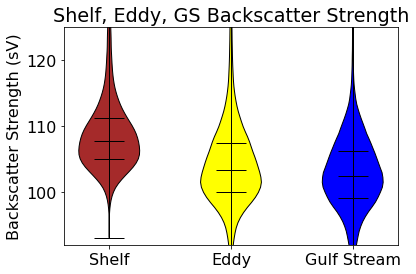

(108.97964, 104.28646, 102.745026)

In [62]:
# Create figure with three axes
fig, ax = plt.subplots()

# Plot violin plot on axes 1
parts = ax.violinplot([np.concatenate(shelf_ek),np.concatenate(eddy_ek),np.concatenate(gulf_stream_ek)], positions=[0,1,2], quantiles=[[.25,.50,.75],[.25,.50,.75],[.25,.50,.75]])
# ax1.set_title('Shelf')
ax.set_ylim(92,125)

cs = ['brown', 'yellow', 'blue']

for i,pc in enumerate(parts['bodies']):
    pc.set_facecolor(cs[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    
for partname in ('cbars','cmins','cmaxes', 'cquantiles'):
    vp = parts[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)
    
ax.set_xticks([0,1,2])
ax.set_xticklabels(['Shelf', 'Eddy', 'Gulf Stream'])

ax.set_title("Shelf, Eddy, GS Backscatter Strength")
ax.set_ylabel('Backscatter Strength (sV)')
# plt.savefig('backscatter_strength.png',dpi=300)
plt.show()

np.concatenate(shelf_ek).mean(), np.concatenate(eddy_ek).mean(),np.concatenate(gulf_stream_ek).mean()

### Look at each of the transects in the ADCP data

0
data/sept_cruise/adcp/processed/101706_20210905T145056UTC_100s


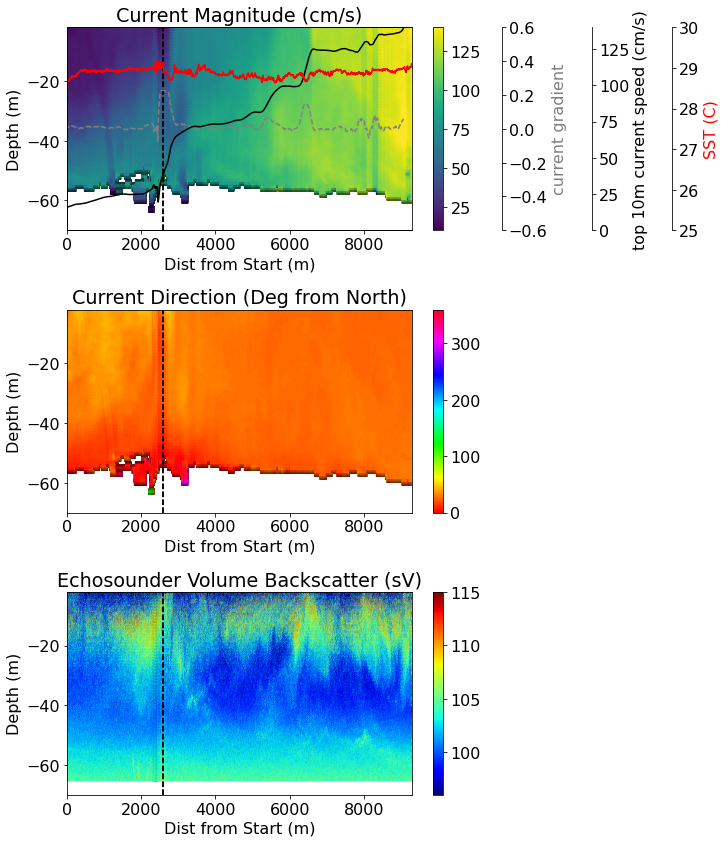

--------------------------------------


In [64]:
for idx,fn in enumerate(filenames):
    print(idx)
    print(fn)
    
#     try:

    dist = scipy.io.loadmat(fn+'_distance.mat')['distance']
    sst = scipy.io.loadmat(fn+'_SST.mat')['SST']
    time = scipy.io.loadmat(fn+'_time.mat')['time']
    timestamps = pd.to_datetime(time[0,:]-719529, unit='D')

#         if idx in [5,28,39,40,41]:
#             dist = (dist - dist[-1])*-1

    X = scipy.io.loadmat(fn+'_X.mat')['X']
    Y = scipy.io.loadmat(fn+'_Y.mat')['Y']
    vMag = scipy.io.loadmat(fn+'_vmag.mat')['C']

    vDir = scipy.io.loadmat(fn+'_vdir.mat')['C']

    echo = scipy.io.loadmat(fn+'_echo.mat')['C']
    Xecho = scipy.io.loadmat(fn+'_Xecho.mat')['X']
    Yecho = scipy.io.loadmat(fn+'_Yecho.mat')['Y']
    # correcting for the smaller bin size
    Yecho = (Yecho*0.502)-1

    lat = scipy.io.loadmat(fn+'_lat.mat')['lat']
    long = scipy.io.loadmat(fn+'_long.mat')['long']
    
    adcp_df = pd.DataFrame({'dt':timestamps,
                    'datetime':timestamps,
                   'lat': lat[:,0],
                   'lon':long[:,0],
                           'dist':dist[:,0]})

    adcp_df = adcp_df.set_index('dt')
    adcp_df = adcp_df.sort_index(ascending=True)

#     plot_profiles(profiles, adcp_df, timestamps[0],timestamps[-1], ['temp (C)', 'salinity (PSU)', 'chla (ppb)'], plot=True)

    fig, ax = plt.subplots(3,1, figsize=(10,12))
    vMag_reshape = vMag.reshape(-1,69).T
    vDir_reshape = vDir.reshape(-1,69).T

#         if idx in [5,28,39,40,41]:
#             vMag_reshape = np.fliplr(vMag_reshape)
#             vDir_reshape = np.fliplr(vDir_reshape)

    x, y = np.meshgrid(X.reshape(-1,69)[:,0],Y[:69,0])    
    im = ax[0].pcolormesh(x,y,vMag_reshape,shading='gouraud', vmin=10,vmax=140)
    fig.colorbar(im,ax=ax[0])
    ax[0].set_title("Current Magnitude (cm/s)")

    im = ax[1].pcolormesh(x,y,vDir_reshape,shading='gouraud', vmin=0,vmax=360, cmap='hsv')
    fig.colorbar(im,ax=ax[1])
    ax[1].set_title("Current Direction (Deg from North)")

    vgradient = []

    N=180
    current_speed = np.mean(vMag_reshape[0:4,:],axis=0)
    current_speed_smooth = pd.Series(current_speed).rolling(window=N).mean().iloc[N-1:].values
    vgradient = []

    step = 1

    for i in range(len(current_speed)-N):
        du = current_speed_smooth[i] - current_speed_smooth[i+step]
        dx = dist[i] - dist[i+step]
        current_grad = du/dx
        vgradient.append(current_grad)

    dudx = scipy.signal.savgol_filter(current_speed_smooth, window_length=11, polyorder=2, deriv=1)

    ax_twin = ax[0].twinx()
#         ax_twin.plot(dist[15:-15-N], vgradient_smooth[15:-16], c='k', alpha=0.5)
    ax_twin.plot(dist[:-N+1], dudx, c='grey', ls='--')
    ax_twin.set_ylim(-0.6,0.6)

    ax_twin2 = ax[0].twinx()
    ax_twin2.plot(dist[:-N],current_speed_smooth[:-1],c='black')
    ax_twin2.set_ylim(0,140)

    ax_twin3 = ax[0].twinx()
    ax_twin3.plot(dist,sst, color='red')
    ax_twin3.set_ylim(25,30)
    # taking off the first 100 points because those are often noisy and never the front
    front_location = np.argmax(np.abs(dudx[100:-30]))+100

    echo_reshape = echo.reshape(-1,127).T
#         vDir_reshape = vDir.reshape(-1,69).T

#         if idx in [5,28,39,40,41]:
#             echo_reshape = np.fliplr(echo_reshape)

    x, y = np.meshgrid(Xecho.reshape(-1,127)[:,0],Yecho[:127,0])    

    im = ax[2].pcolormesh(x,y,echo_reshape,shading='gouraud', vmin=96,vmax=115, cmap='jet')
    fig.colorbar(im,ax=ax[2])
    ax[2].set_title("Echosounder Volume Backscatter (sV)")

    ax_twin.yaxis.label.set_color('grey')
    ax_twin.spines['right'].set_position(('outward', 90))

    ax_twin2.yaxis.label.set_color('black')
    ax_twin2.spines['right'].set_position(('outward', 180))

    ax_twin3.yaxis.label.set_color('red')
    ax_twin3.spines['right'].set_position(('outward', 260))

    ax_twin.set_ylabel('current gradient')
    ax_twin2.set_ylabel('top 10m current speed (cm/s)')
    ax_twin3.set_ylabel('SST (C)')

    if idx == 3:
        for i in range(3):
            ax[i].set_xlim(dist.max(),0)
    else:
        for i in range(3):
            ax[i].set_xlim(0,dist.max())
    for i in range(3):
        ax[i].axvline(dist[front_location],color='k', ls='--')
        ax[i].set_ylim(-70,-2)
        ax[i].set_ylabel('Depth (m)')
        ax[i].set_xlabel('Dist from Start (m)')
        ax[i].axvline(dist[front_location],color='k', ls='--')

    fig.tight_layout()

#         fig.savefig('mag_dir_echo'+str(idx)+'.png',dpi=400)
    plt.show()

    print('--------------------------------------')

#     except Exception as e: 
#         print(e)
    
    break